In [1]:
# Retrieve variable df from preparation notebook
%store -r df_with_outliers

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import polars as pl
import polars.selectors as cs

In [3]:
print(df_with_outliers.shape)
df = df_with_outliers

(157052, 51)


## Remove outliers

### Visualize them

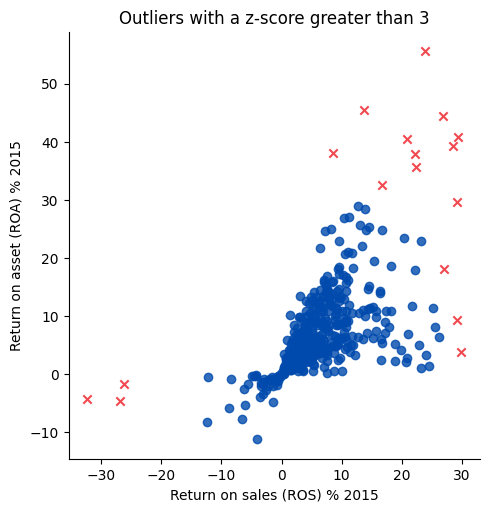

In [4]:
dfa = df.to_pandas()
# creating the column with outliers that are the standardized values >= 3 for ROS and ROA
dfa['outlier'] = ((np.abs((dfa['Return on sales (ROS) % 2015'] - dfa['Return on sales (ROS) % 2015'].mean()) / dfa['Return on sales (ROS) % 2015'].std(ddof=0)) >= 3) | 
(np.abs((dfa['Return on asset (ROA) % 2015'] - dfa['Return on asset (ROA) % 2015'].mean()) / dfa['Return on asset (ROA) % 2015'].std(ddof=0)) >= 3))

custom = ["#004aad", "#ed1c24"]
sns.set_palette(custom)
# scatter plot with outliers defined with cross
sns.lmplot(data=dfa.sample(500, random_state=2054), legend=False, fit_reg=False, 
    x="Return on sales (ROS) % 2015", y="Return on asset (ROA) % 2015", hue="outlier", 
    markers=["o", "x"]);
plt.xlim=([-14, 30])
plt.ylim=([-15, 50])
plt.title("Outliers with a z-score greater than 3") 
plt.show()

### Let's drop them

In [5]:
print(df.shape)
dfp = df.to_pandas() # from polars to pandas dataframe
df_sub = df.select((cs.ends_with("2014") | cs.ends_with("2015")) & cs.float()).to_pandas() # taking the financial indicators to drop the outliers
cols = df_sub.columns 

lim = np.abs(stats.zscore(df_sub)) < 3 # defining outliers for zscore values >=3

dfp.loc[:, cols] = df_sub.where(lim, np.nan) # nan values to outliers values for the financial indicators

df = pl.from_pandas(dfp.dropna(subset=cols)) # drop nan values (so outliers) from the dataframe

print(df.shape)

(157052, 51)
(117505, 51)


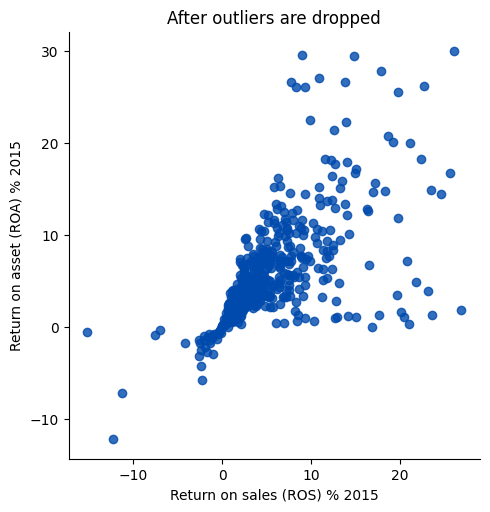

In [6]:
custom = ["#004aad"]
sns.set_palette(custom)
# scatter plot without outliers
sns.lmplot(data=df.to_pandas().sample(500, random_state=2054), legend=False, fit_reg=False, x="Return on sales (ROS) % 2015", y="Return on asset (ROA) % 2015");
plt.xlim=([-14, 30])
plt.ylim=([-15, 50])
plt.title("After outliers are dropped") 
plt.show()

## Descriptive analysis

### Financial ratios on the status

/tmp/ipykernel_388/469625613.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(subset['Leverage 2015'], hist=False, kde=True,
/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_388/469625613.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
sim

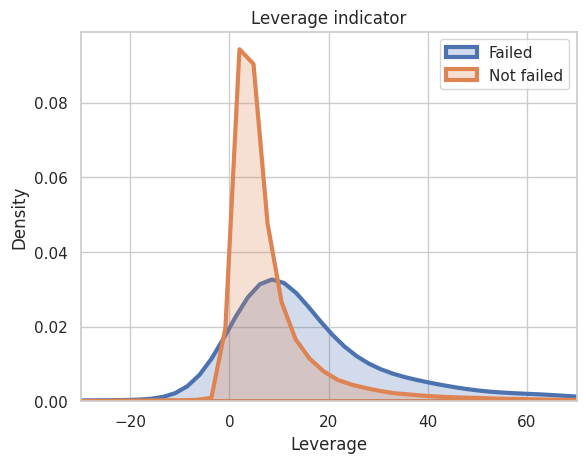

In [11]:
int_status = df.select(pl.col("Leverage 2015", "status" )) # select interest/EBIT and status for the plot

sns.set(style="whitegrid")

for status in (True, False):
    subset = int_status.filter(pl.col("status") == status) # if the status is the one of the dataframe
   
    # Draw the density plot with different colors for each category
    ax = sns.distplot(subset['Leverage 2015'], hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 3},
                 label=status)

# Plot formatting
ax.legend(prop={'size': 10})
ax.set_title('Leverage indicator')
ax.legend(["Failed", "Not failed"])
ax.set(xlabel='Leverage')
ax.set(ylabel='Density')
ax.set(xlim=(-30,70))

plt.show()

### Difference between industries

/tmp/ipykernel_388/3581854468.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(subset['Sales to total assets 2015'], hist=False, kde=True,
/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_388/3581854468.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level fu

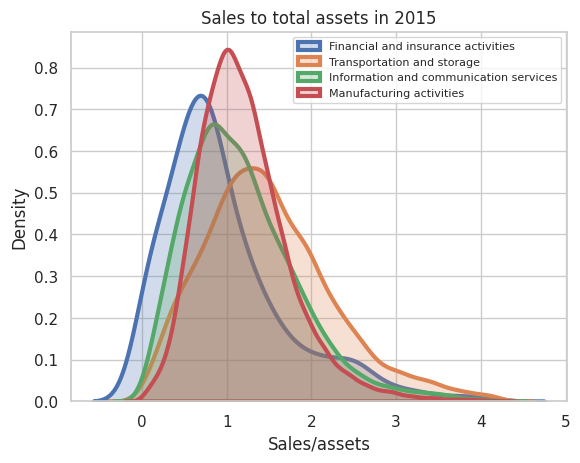

In [12]:
int_sector = df.select(pl.col("Sales to total assets 2015", "ateco_title" )) # selec sales/asset indicator and industries for the plot

sns.set(style="whitegrid")

for sector in ("ATTIVITÀ FINANZIARIE E ASSICURATIVE",  "TRASPORTO E MAGAZZINAGGIO", "SERVIZI DI INFORMAZIONE E COMUNICAZIONE", "ATTIVITÀ MANIFATTURIERE"): # selecting only 4 sectors for the density plot
    subset = int_sector.filter(pl.col("ateco_title") == sector)
   
    # Draw the density plot with different colors for each category
    ax = sns.distplot(subset['Sales to total assets 2015'], hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 3},
                 label=sector)

# Plot formatting
ax.legend(["Financial and insurance activities", "Transportation and storage", "Information and communication services", "Manufacturing activities"], prop={'size': 8}, loc="upper right")
ax.set_title('Sales to total assets in 2015')
ax.set(xlabel='Sales/assets')
ax.set(ylabel='Density')

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cda3dc7f-2383-4ca3-97fb-1b86671fd3dc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>